# Rapport projet: exercice 1

L'objectif de cet exercice est de recoder à la main un algorithme de gradient Boosting multi-classes. Ce programme sera par la suite testé sur le jeu de données Iris qui a la particularité d'être simple et est un bon exemple pour la classification multi-classes. Une comparaison sera également faite en comparant les matrices de confusion respective à cet algorithme recoder et celui du Gradient Boosting de sklearn. Puis une fonction de perte sera calculée.

In [6]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
import math

# Pour normaliser et standardiser les données
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

## I. Question 1

L'algorithme programmé ci-dessous est fortement inspiré du pseudo-code présent sur le moodle du cours de Statistique en grande dimension à la page 13. On retrouvera ce pseudo-code dans le rapport écrit, de plus, ce document est cité en référence pour cet exercice. Voici le pseudo-code : 

<img src="pseudo_code_GB.png" style="height:300px">

Maintenant, comment fonctionne cet algorithme ? De ce que j'ai compris, l'algorithme du Gradient boosting est en fait une succession de prédiction de résidus par des apprenants faibles. A chaque itération, on somme les nouveaux résidus prédits avec les précédents en n'oubliant pas de multiplier par un $pas$. Ainsi, ce qui sort de cet algorithme au final, sont les classes préditent à laquelle on définit une règle de décision pour retrouver les classes. Cet algorithme étant résumé, regardons un peu plus en profondeur. C'est-à-dire comment est initialisé l'algorithme ? Comment les résidus sont calculés ? Quelle est l'importance du $pas$ ? Pourquoi est-ce que l'on somme les résidus ? Et enfin comment est calculée la fonction de perte ?

### I.1 Initialisation du programme

Comme indiqué dans le pseudo-code, l'initialisation commence en initialisant notre variable $F$ par que des 0. Ensuite, l'étape suivante consiste à attribuer une probabilité pour chaque individu d'appartenir à la classe k (K étant le nombre total de classe). Cette probabilité est calculée à partir de la fonction $softmax$ comme suit :

$$p_k(i) \quad = \quad \frac{e^{F_k(i)}}{\sum_{l=1}^K e^{F_l(i)}} \quad k\in[1,...,K] $$

Pour la première itération, comme $F$ ne contient que des 0, on a :

$$p_k(i) \quad = \quad \frac{e^{0}}{\sum_{l=1}^K e^{0}} \quad = \quad \frac{1}{K} $$

Ainsi, au départ nous avons la même probabilité pour tous les individus. A chaque itération, les nouvelles probabilités seront calculées de la même manière. L'étape suivante consiste maintenant à déterminer les résidus.

### I.2 Les résidus et apprenant faible

A chaque itération de l'algorithme, après que de nouvelles probabilités seront calculées, on détermine les résidus. Ces résidus sont tous simplement la différence entre les classes $Y$ et les probabilités associées. On a alors :

$$residu \quad = \quad y_{ik} \text{ } - \text{ } p_k(i)$$

Ensuite, on entraine un apprenant faible (comme un arbre de décision ou bien un RandomForest par exemple) sur ces résidus avec les données d'entrainements. Par suite, on met à jour un nouveau $F$ qui est la somme des résidus prédits par l'apprenant faible. Un $pas$, ou un $learning rate$ multiplie ces prédictions. Ainsi on itère cet algorithme jusqu'au dernier apprenant faible disponible.

### I.3 Pourquoi ça marche

En travaillant l'algorithme pas à pas, on constate que les probabilités sont de plus en plus petites et par conséquent, les résidus se rapprochent de leurs classes respectives jusqu'à les dépasser (surapprentissage). On note une particularité pour la classe 0, c'est que pour cette classe, les résidus sont toujours négatifs et grâce à notre règle de décision, cette classe sera toujours bien prédite. 

$\\$

Maintenant, à quoi sert le $learning rate$ ? Celui à la particularité d'être compris entre 0 et 1, par conséquent il "atténue" la somme des prédictions des apprenants faibles ce qui à donc l'avantage d'éviter le surapprentissage et voir l'algorithme faire n'importe quoi. Ainsi, en appliquant la règle de décision sur le dernier $F$ calculé, c'est-à-dire la dernière somme des prédictions du dernier apprenant faible, on obtient notre $Y$ prédit par la méthode du Gradient boosting. Une fonction de perte est aussi demandé.

### I.4 Fonction de perte

Il y a plusieurs façons de calculer une fonction de perte. Pour reprendre le rapport sur moodle, la méthode choisie est donc l'entropie croisée comme suit:

$$l(y_i,f(x_i)) \quad = \quad - \text{ } \sum_{k=1}^K \mathbb{1}_{y_{ik}\ne F_k(i)} \text{ } * \text{ } log(p_k(xi)) $$

Pour cela, à chaque calcul d'un nouveau $F$, on applique la règle de décision pour convertir en classe, puis on compare avec notre $Y$ d'entrainement. A chaque erreur de prédiction, on calcule cette valeur.

### I.5 Le code : brève explication

L'algorithme a été introduit, voici maintenant le code commenter en détail. Celui-ci est codé sous forme de $class$ (plus pratique d'utilisation). Expliquons maintenant ce que fait chaque paramètre. Comme demandé, on prend en argument nos données $X$ et $Y$ au préalable normalisé. Ensuite, l'argument $n \text{ } apprenant \text{ }faible$ doit être une liste à quatre éléments puisque seulement quatre types d'apprenant faible sont possibles. Il s'agit respectivement du $RandomForest$, $Bagging$, $DecisionTree$ et $KNN$. Ainsi, le premier élément de la liste appliquera un apprenant du type $RandomForest$, le second un algorithme de $Bagging$, etc.... 

Par exemple, si je renseigne en argument la liste suivante : $[1,0,2,1]$, alors le programme appliquera un $RandomForest$, deux $DecisionTree$ et un $KNN$ comme apprenants faibles. Ensuite, le $learnin rate$ est un chiffre compris entre 0 et 1 et $n \text{ } bootstrap$ est aussi compris entre 0 et 1 et indique la proportion de données tests et d'entrainements qui divisent l'échantillon. Il est également à noter que dans le programme les méthodes de régression sont utilisées pour entrainer les apprenants faibles. Cela est normal car les données qui sont manipulées (les résidus) sont des chiffres décimaux, et python ne considère pas cela comme des groupes et par conséquent les méthodes de classification sont inutilisables (une erreur est renvoyée). Heureusement, les méthodes de régression font la même chose. 

In [7]:
class Gradient_boosting():
    def __init__(self, X, Y, n_apprenant_faible, learning_rate, n_boostrap):
        self.X=X
        self.Y=Y
        self.n_apprenant_faible=n_apprenant_faible
        self.learning_rate=learning_rate
        self.n_boostrap=n_boostrap

    def choix(self):
        """
        Cette fonction sert à retourner une liste de tous les apprenants faibles que l'on a souhaités en renseignant l'argument : n_apprenant_faible. 
        Le but est d'avoir la possibilité de mettre autant d'apprenant faible que l'on souhaite parmi les 4 possibles. 
        Par exemple, si je veux seulement 3 RandomForest, en ayant renseigné la liste [3,0,0,0], alors cette fonction retournera : 
        [RandomForestRegressor(),RandomForestRegressor(),RandomForestRegressor()]
        """
        # Voici les 4 types d'apprenants faible possible pour ce programme du Gradient boosting
        apprenant_faible=[RandomForestRegressor(),BaggingRegressor(),DecisionTreeRegressor(),KNeighborsRegressor()] 
        apprenant=[]
        for k in range (len(self.n_apprenant_faible)):
            nb=0
            while nb != self.n_apprenant_faible[k]:
                apprenant.append(apprenant_faible[k])
                nb+=1
        
        return apprenant
    
    def regle_de_decision(self, y_pred):
        """
        Cette fonction va servir à appliquer une règle qui nous permettra de convertir nos valeurs calculées entier. 
        0,1,2 pour trois classes par exemple.
        """
        K=list(set(self.Y))
        y_copy=np.copy(y_pred)
        for k in range(len(K)):
            for i in range(len(y_pred)):
                if y_copy[i]<=K[0]:
                    y_copy[i]=K[0]
                elif y_copy[i]>K[k-1] and y_copy[i]<=K[k]:
                    y_copy[i]=K[k]
        
        # Mise sous forme d'entier
        y_copy=[int(y_copy[i]) for i in range(len(y_pred))] # Convertion en entier car la boucle renvoie des floats : 0.0, 1.0, ...
        return y_copy

    def entrainement_gradient_boosting(self,train_test):

        Xtrain, Xtest, Y_train, Y_test = train_test_split(self.X, self.Y, test_size=self.n_boostrap)
        
        # Normalisation des données
        scaler=StandardScaler()
        X_train=scaler.fit_transform(Xtrain)
        X_test=scaler.fit_transform(Xtest)
        
        """
        Choix : soit on choisit d'entrainer sur les données d'entrainement soit sur les données tests.
        Ceci est mis en place pour nous permettre de calculer l'entropie croisée sur les données tests
        """
        if train_test=="train":
            X=np.copy(X_train)
            Y=np.copy(Y_train)
        elif train_test=="test":
            X=np.copy(X_test)
            Y=np.copy(Y_test)            

        """
        Initialisation de l'algorithme
        """
        K=list(set(Y))
        F=[]    
        F.append([0 for i in range(len(Y))]) # initialisation, tt le monde à 0
        P=[1/len(K) for i in range(len(Y))] # pkm initial = 1/K
        
        # Programmation de l'algorithme de Gradient Boosting
        liste_apprenant=[]
        apprenant=Gradient_boosting.choix(self) # Récupération des apprenants faibles à utiliser
        entropie_croiser=[]

        for m in range(len(apprenant)):

            """
            Etape 1 : Grâce à la fonction softmax, on calcule la probabilité conditionnelle pk(xi) d'appartenance à la classe k.
            """
            denominateur=0
            if m==0:
                new_K=[0 for i in range(len(K))] # nécessite de différencier le cas m=0 car au départ on a que des 0
            else: new_K=list(set(F[m]))

            for k in range(len(K)):
                denominateur+= np.exp(new_K[k]) # Somme(exp(Fkm))

            # Calcul de pk(xi), la fonction softmax
            for j in range(len(Y)):
                P[j]=round(np.exp(F[m][j])/denominateur,5) # exp(Fkm)/Somme(exp(Flm)) pour l = 1,...,K

            """
            Etape 2 : Calcul des résidus, descente de gradient. Il s'agit tout simplement de la différence entre 
            les Yi et la probabilité associée d'appartenir à la classe Yi
            """
            residu=[Y[i]-P[i] for i in range(len(Y))]
            
            """
            Etape 3 : Entrainement des apprenants faibles sur les résidus. On stocke en même temps les apprenants qui sont entrainés. 
            """
            clf=apprenant[m]
            clf.fit(X,residu)
            pred=clf.predict(X)
            liste_apprenant.append(clf)
            
            """
            Etape 4 : Mise à jour des nouvelles valeurs et introduction du learning rate. A noter que la fonction
            round est là juste pour arrondir à 5 chiffres pour éviter d'avoir des valeurs > K ce qui planterait tout l'algo
            """
            F.append([F[m][i] + self.learning_rate*round(pred[i],5) for i in range(len(Y))])
            
            """
            Etape 5 : Calcul de l'entropie croisée pour la fonction de perte
            """
            classe=Gradient_boosting.regle_de_decision(self, F[-1])
            loss=[]
            for i in range(len(Y)):
                if Y[i] != classe[i]:
                    loss.append(-math.log(P[i]))

            entropie_croiser.append(sum(loss))
            
        return m, F, entropie_croiser, liste_apprenant, X_train, X_test, Y_train, Y_test

    def predictions(self):
        """
        Cette fonction va effectuer des prédictions sur les données tests. Pour cela, on récupère tous les apprenants entrainés dans la fonction
        précédente. Puis on les entraine sur les données tests en oubliant pas le learning rate. On effectue une somme de ces prédictions et
        on applique à cette somme notre règle de décision.
        """
        m, F, entropie_croiser, liste_apprenant, X_train, X_test, Y_train, Y_test = Gradient_boosting.entrainement_gradient_boosting(self,"train")
        y_pred_estimate=np.zeros(len(Y_test))

        entropie_croiser_test=[]
        for learning in liste_apprenant:
            pred=learning.predict(X_test)
            for i in range(len(y_pred_estimate)):
                y_pred_estimate[i]+=self.learning_rate*pred[i]

        y_pred_estimate=Gradient_boosting.regle_de_decision(self, y_pred_estimate)
    
        return m, X_train, X_test, Y_train, Y_test, y_pred_estimate

    
    def matrice_confusion(self):
        """
        Comme son nom l'indique, on va plot une matrice de confusion et également celle du Gradient boosting de
        sklearn avec les mêmes paramètres pour pouvoir comparer notre algorithme.
        """

        m, X_train, X_test, Y_train, Y_test, y_pred_estimate = Gradient_boosting.predictions(self)

        # On calcul l'accuracy
        print("Voici l'accuracy de cette algorithme : ", accuracy_score(Y_test,y_pred_estimate))

        # Entrainement et prédictions avec le GB de sklearn
        verification=GradientBoostingClassifier(n_estimators=m, learning_rate= self.learning_rate)
        verification.fit(X_train, Y_train)
        y_pred=verification.predict(X_test)

        print("Voici l'accuracy du Gradient boosting de sklearn : ", accuracy_score(Y_test,y_pred))

        fig,axes = plt.subplots(1,2,figsize=(15,5))
        conf_matrix_estimate=confusion_matrix(Y_test,y_pred_estimate)
        sns.heatmap(conf_matrix_estimate, annot = True ,cmap="Blues",ax=axes[0])
        axes[0].set_xlabel("Predicted label")
        axes[0].set_ylabel("True label")
        axes[0].set_title("Gradient Boosting estimé")

        conf_matrix=confusion_matrix(Y_test,y_pred)
        sns.heatmap(conf_matrix, annot = True ,cmap="Reds",ax=axes[1])
        axes[1].set_xlabel("Predicted label")
        axes[1].set_ylabel("True label")
        axes[1].set_title("Gradient Boosting de sklearn")

    
    def loss_function(self):
        """
        On calcule ici la fonction de perte associée à cette algo. Pour cela on récupère le calcul
        de l'entropie croisée calculer dans la fonction d'entrainement du modele. Ensuite, on applique 
        également la fonction d'entrainement sur les données tests pour avoir également les erreurs tests sur le même graphique
        """

        _,_, entropie_croiser,_, _,_,_,_=Gradient_boosting.entrainement_gradient_boosting(self,"train")
        _,_, entropie_croiser_test,_,_,_,_,_ = Gradient_boosting.entrainement_gradient_boosting(self,"test")
        
        fct_perte=pd.DataFrame()
        fct_perte["Loss train"]=entropie_croiser
        fct_perte["Validation test"]=entropie_croiser_test
        fct_perte.plot()
        plt.title("Fonction de perte estimé par entropie croisée")


## Question 2

Comme énoncés en introduction, nous allons appliquer le script python ci-dessus au jeu de données $Iris$. Ainsi, nous allons essayer de prédire les trois espèces différentes d'Iris avec notre programme et comparer nos résultats avec la méthode donnée par sklearn. On affichera également la fonction de perte. Commençons d'abord par charger le jeu de données Iris de sklearn. 

In [8]:
iris=datasets.load_iris() # Chargement du jeu de données du package sklearn
X_iris=iris.data
y_iris=iris.target

On se propose maintenant comme première demonstration, de prendre arbitrairement 6 arbres de décision. 

Voici l'accuracy de cette algorithme :  0.8333333333333334
Voici l'accuracy du Gradient boosting de sklearn :  0.9


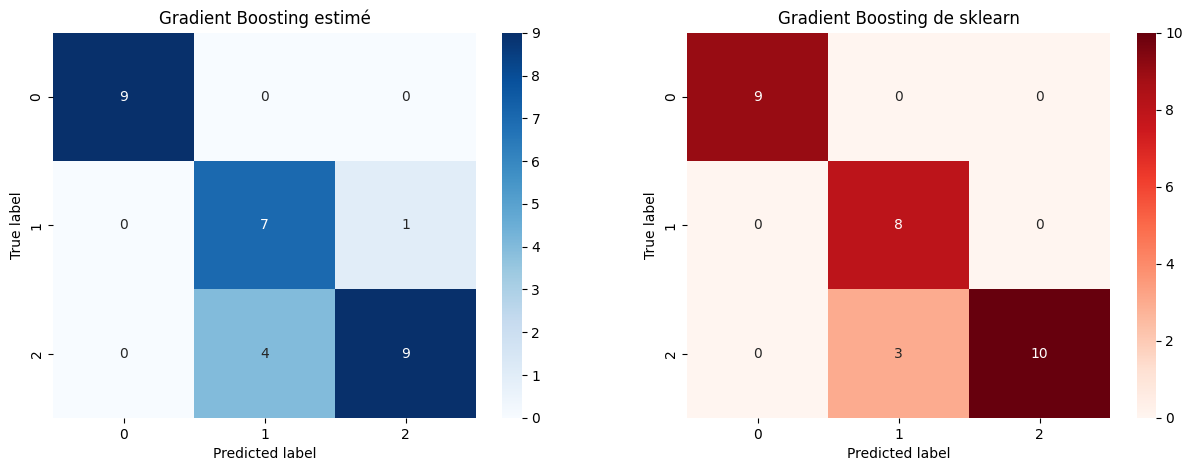

In [9]:
Gradient_boosting(X_iris, y_iris, [0,0,6,0],0.2,0.2).matrice_confusion()

En comparant les matrices de confusion et même le score de l'accuracy que les résultats sont presque semblable, seul quelques données sont mal classée. Regardons maintenant la fonction de perte.

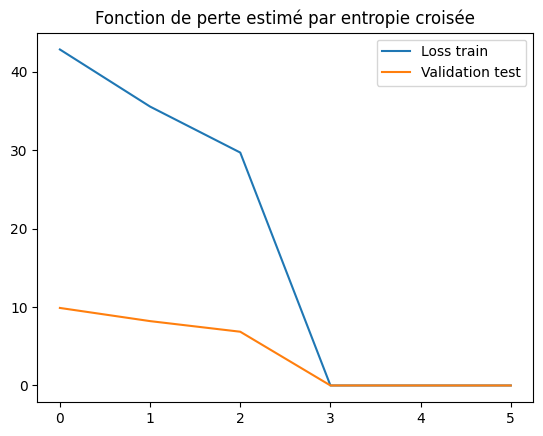

In [10]:
Gradient_boosting(X_iris, y_iris, [0,0,6,0],0.2,0.2).loss_function()

Comme il est demandé dans l'énoncé de voir comment fonctionne la méthode des K plus proches voisins avec cet algorithme, nous allons donc faire une seconde démonstration en prenant dans un premier temps, trois apprenants faible du type K plus proches voisins, regardons ce que cela donne :

Voici l'accuracy de cette algorithme :  0.6666666666666666
Voici l'accuracy du Gradient boosting de sklearn :  0.9666666666666667


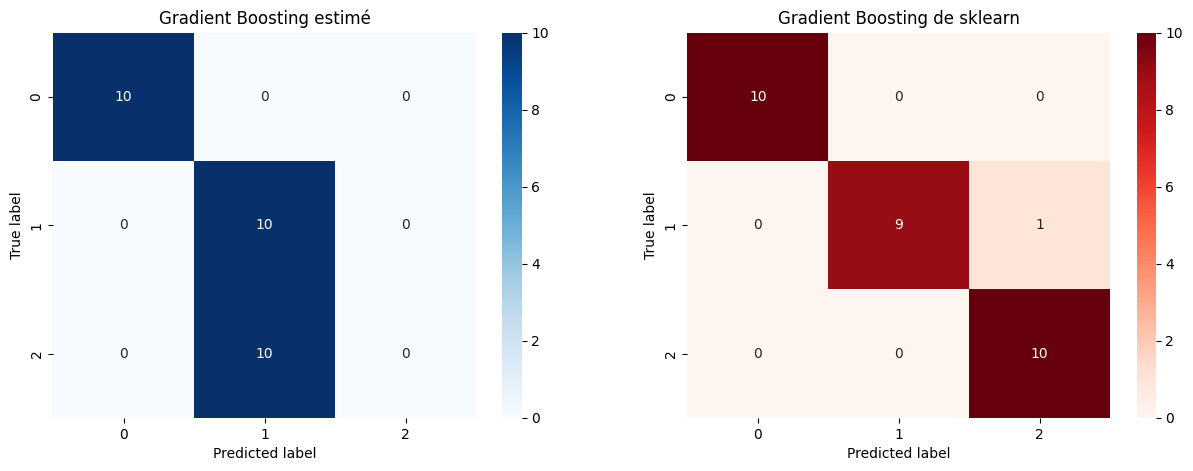

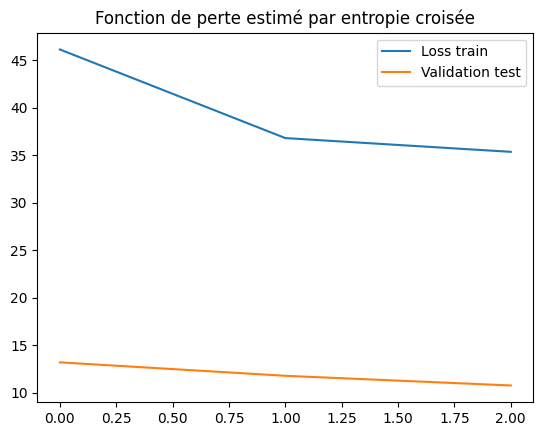

In [11]:
Gradient_boosting(X_iris, y_iris, [0,0,0,3],0.2,0.2).matrice_confusion()
Gradient_boosting(X_iris, y_iris, [0,0,0,3],0.2,0.2).loss_function()

Les résultats ici ne sont pas très concluant. Essayons d'augmenter le nombre d'apprenant faible.

Voici l'accuracy de cette algorithme :  0.9
Voici l'accuracy du Gradient boosting de sklearn :  0.8666666666666667


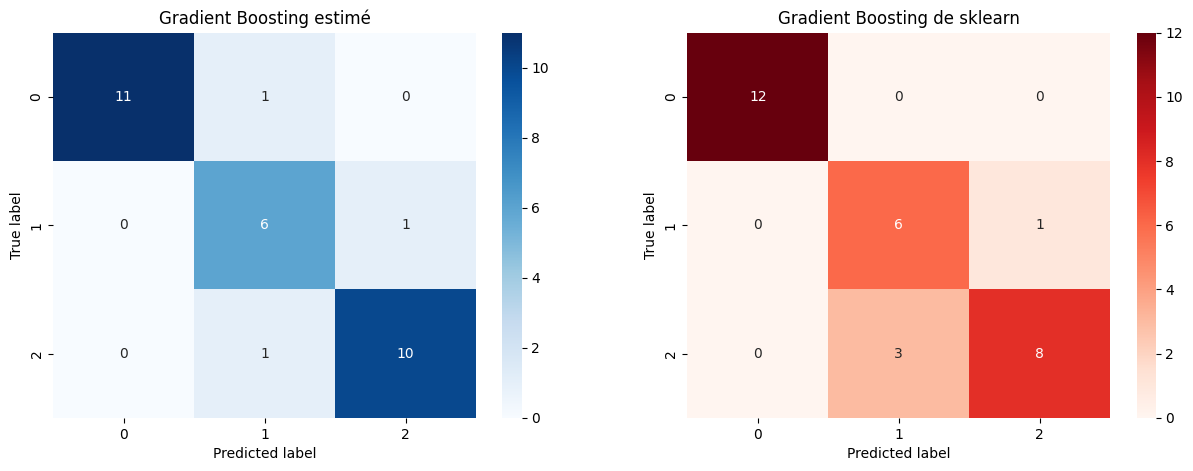

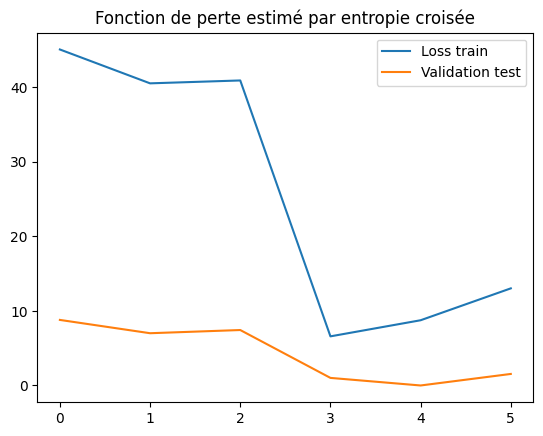

In [12]:
Gradient_boosting(X_iris, y_iris, [0,0,0,6],0.2,0.2).matrice_confusion()
Gradient_boosting(X_iris, y_iris, [0,0,0,6],0.2,0.2).loss_function()

## Conclusion

Les résultats semblent meilleurs, on peut donc dire que prendre une méthode de k plus proche voisins comme apprenant faible marche à condition d'en mettre suffisamment. On note aussi un léger surapprentissage à partir du rang 4 (soit 5 en comptant le zéro) en regardant la fonction de perte.

Il est à noter aussi que les exemples illustrés n'utilisent que des apprenants du même type, mais on aurait très bien pu combiner les apprenants. Il suffit pour cela de jouer avec les nombres que l'on souhaite mettre dans la liste. Un exemple de plusieurs apprenants faibles est illustré dans le rapport écrit.

## Annexe

Cours sur le Gradient Boosting : https://moodle.univ-angers.fr/pluginfile.php/2522785/mod_resource/content/1/adrien_maitammar_projet_annuel_m2_ds.pdf
